In [17]:
import tensorflow as tf

for layers in model.layers:
    print(layers.name)

ValueError: tf.enable_eager_execution must be called at program startup.

(1, 336, 512, 3)


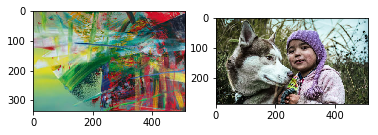

In [10]:
import tensorflow as tf

tf.enable_eager_execution()

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

img =load_img('style_image.jpg')
content_img = load_img('ghostu.jpg')
from matplotlib import pyplot as plt
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(img[0])
plt.subplot(1,2,2)
plt.imshow(content_img[0])

In [7]:
content_layers = ['block5_conv2']

style_layers=['block1_conv1',
              'block2_conv1',
              'block3_conv1',
              'block4_conv1',
              'block5_conv1']
numCL = len(content_layer)
numSL = len(style_layer)

def vgg_layers(layer_name):
    model = tf.keras.applications.VGG19(include_top = False, weights='imagenet')
    model.trainable=False
    
    outputs = [model.get_layer(name).output for name in layer_name]
    print(outputs)
    model = tf.keras.Model([model.input],outputs)
    
    return model

style_extractor = vgg_layers(style_layer)
style_output = style_extractor(img*255)

for name, output in zip(style_layers, style_output):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    


[<tf.Tensor 'block1_conv1_2/Identity:0' shape=(?, ?, ?, 64) dtype=float32>, <tf.Tensor 'block2_conv1_2/Identity:0' shape=(?, ?, ?, 128) dtype=float32>, <tf.Tensor 'block3_conv1_2/Identity:0' shape=(?, ?, ?, 256) dtype=float32>, <tf.Tensor 'block4_conv1_2/Identity:0' shape=(?, ?, ?, 512) dtype=float32>, <tf.Tensor 'block5_conv1_2/Identity:0' shape=(?, ?, ?, 512) dtype=float32>]
block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  771.22516
  mean:  28.013376
block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  3944.7876
  mean:  146.03596
block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  9271.762
  mean:  158.19206
block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  17933.709
  mean:  560.21265
block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  2482.3616
  mean:  38.124355


In [16]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc, bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num)

class StyleContentModel(tf.keras.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.numSL = len(style_layer)
        self.vgg.trainable = False
    
    def call(self, inputs):
        inputs = inputs*255
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.numSL], outputs[self.numSL:])
        
        style_outputs = [gram_matrix(op) for op in style_outputs]
        
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name:value for style_name,value in zip(self.style_layers, style_outputs)}
        
        return {'content':content_dict, 'style':style_dict}
    
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_img))
style_results = results['style']
print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
        


[<tf.Tensor 'block1_conv1_6/Identity:0' shape=(?, ?, ?, 64) dtype=float32>, <tf.Tensor 'block2_conv1_6/Identity:0' shape=(?, ?, ?, 128) dtype=float32>, <tf.Tensor 'block3_conv1_6/Identity:0' shape=(?, ?, ?, 256) dtype=float32>, <tf.Tensor 'block4_conv1_6/Identity:0' shape=(?, ?, ?, 512) dtype=float32>, <tf.Tensor 'block5_conv1_6/Identity:0' shape=(?, ?, ?, 512) dtype=float32>, <tf.Tensor 'block5_conv2_6/Identity:0' shape=(?, ?, ?, 512) dtype=float32>]
Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.042322207
    max:  34720.508
    mean:  622.51434

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  151471.75
    mean:  22952.14

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  449196.12
    mean:  22025.674

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  6611728.0
    mean:  329354.9

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  235778.36
    mean:  3432.7646

Contents:
   block5_conv2
    shape:  (1, 

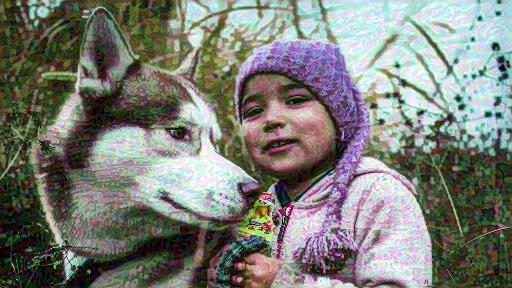

In [25]:
import numpy as np
import PIL

style_targets = extractor(img)['style']
content_targets = extractor(content_img)['content']

image = tf.Variable(content_img)

def clip01(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.train.AdamOptimizer(learning_rate=0.02, beta1 = 0.99, epsilon = 1e-1)

style_weight=1e-2
content_weight=1e4

def style_content_loss(output):
    style_outputs = output['style']
    content_outputs = output['content']
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])

    
    style_loss *= style_weight / numSL
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])

    content_loss *= content_weight / numSL
    
    loss = content_loss + style_loss
    
    return loss

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)



def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss=style_content_loss(outputs)
        
    grad = tape.gradient(loss, image)

    opt.apply_gradients([(grad, image)])
    image.assign(clip01(image))
    
    
train_step(image)
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

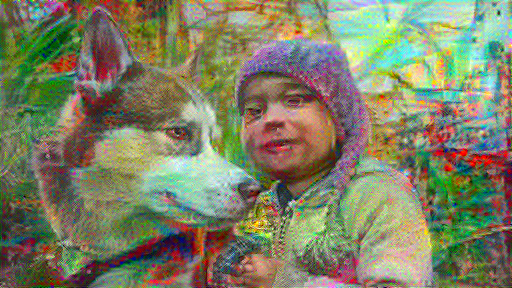

Train step: 1000
Total time: 210.6


In [27]:
import time
from IPython import display

start = time.time()

epochs =  10
spe = 100

step=0

for n in range(epochs):
    for m in range(spe):
        step += 1
        train_step(image)
        print('.', end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))


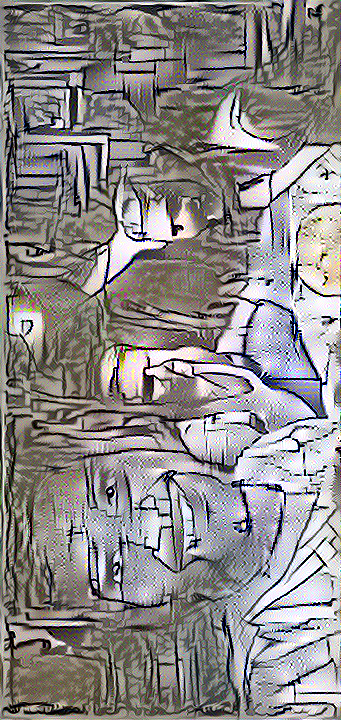

Train step: 700
Total time: 321.4


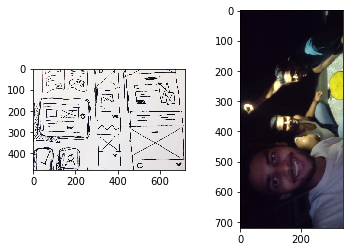

In [2]:
import tensorflow as tf

tf.enable_eager_execution()

content_layers = ['block5_conv2']

style_layers=['block1_conv1',
              'block2_conv1',
              'block3_conv1',
              'block4_conv1',
              'block5_conv1']
numCL = len(content_layers)
numSL = len(style_layers)

def load_img(path_to_img):
    max_dim = 720
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

img =load_img('nst/sketch_ref_2.jpg')
content_img = load_img('nst/kam25.jpeg')
from matplotlib import pyplot as plt
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(img[0])
plt.subplot(1,2,2)
plt.imshow(content_img[0])


def vgg_layers(layer_name):
    model = tf.keras.applications.VGG19(include_top = False, weights='imagenet')
    model.trainable=False
    
    outputs = [model.get_layer(name).output for name in layer_name]
    print(outputs)
    model = tf.keras.Model([model.input],outputs)
    
    return model



def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc, bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num)

class StyleContentModel(tf.keras.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.numSL = len(style_layers)
        self.vgg.trainable = False
    
    def call(self, inputs):
        inputs = inputs*255
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.numSL], outputs[self.numSL:])
        
        style_outputs = [gram_matrix(op) for op in style_outputs]
        
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name:value for style_name,value in zip(self.style_layers, style_outputs)}
        
        return {'content':content_dict, 'style':style_dict}
    
    
    
import numpy as np
import PIL

extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(img)['style']
content_targets = extractor(content_img)['content']

image = tf.Variable(content_img)

def clip01(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.train.AdamOptimizer(learning_rate=0.02, beta1 = 0.99, epsilon = 1e-1)

style_weight=1e-2
content_weight=1e4

def style_content_loss(output):
    style_outputs = output['style']
    content_outputs = output['content']
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])

    
    style_loss *= style_weight / numSL
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])

    content_loss *= content_weight / numSL
    
    loss = content_loss + style_loss
    
    return loss

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)



def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss=style_content_loss(outputs)
        
    grad = tape.gradient(loss, image)

    opt.apply_gradients([(grad, image)])
    image.assign(clip01(image))
    
    
    
import time
from IPython import display

start = time.time()

epochs =  7
spe = 100

step=0

for n in range(epochs):
    for m in range(spe):
        step += 1
        train_step(image)
        print('.', end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

img = tensor_to_image(image)
img.save("nst/kam25Xsketchref2.jpeg")
    